In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle

kaggle.api.authenticate()
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
kaggle.api.dataset_download_files('bwandowando/320k-linkedin-app-google-store-reviews',path='csv_files',unzip=True)

In [3]:
df=pd.read_csv('csv_files/LINKEDIN_REVIEWS.csv')

In [4]:
df

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,cd2c2a2c-750b-435c-823c-277a6dbcef2a,152618553977019693742,A Google user,Well designed app. It's much easier to use tha...,5,0,1.0.3,2011-04-07 15:57:52
1,1,ac8d5093-31ce-4f12-8c6b-ee79a06295ab,234382942865437071667,A Google user,Cool!,5,1,1.0.0,2011-04-07 15:59:50
2,2,bbae055c-f20b-4c01-b604-7cea72416a3a,174473604608358796368,A Google user,Great to finally see this on the market!,5,0,2.0.5,2011-04-07 16:16:02
3,3,38a13596-b208-423d-8d96-3199e1993138,286593453219054880269,A Google user,Great app,5,1,1.0.0,2011-04-07 16:22:27
4,4,9ddd29ce-b137-4286-9aa1-3bbdd0015e0a,167276875678680630145,A Google user,Finally! Would love a Homeycomb specific versi...,4,0,1.0.0,2011-04-07 17:41:58
...,...,...,...,...,...,...,...,...,...
322636,322636,171c29e4-f949-4184-a855-088601940556,275678628651535885903,Di***********gh,Better experience,5,0,4.1.884,2023-11-18 03:28:03
322637,322637,60bb1c67-895f-4cd9-8dcd-75e265964304,133930640114614566822,Da*******rd,Great networking app!,5,0,4.1.884,2023-11-18 03:28:03
322638,322638,aacd49a4-d8ab-412b-b524-3b4e08c9cbcb,128371033984564098315,Si***********li,For the love of God! Please activate your cust...,2,0,4.1.884,2023-11-18 03:42:56
322639,322639,b2af83e8-5ee5-43b0-98ca-1cdc975b0780,236018248827476569871,Ju***************ez,Excepcional,5,0,4.1.881,2023-11-18 03:59:58


### Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322641 entries, 0 to 322640
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          322641 non-null  int64 
 1   review_id           322641 non-null  object
 2   pseudo_author_id    322641 non-null  object
 3   author_name         322641 non-null  object
 4   review_text         320925 non-null  object
 5   review_rating       322641 non-null  int64 
 6   review_likes        322641 non-null  int64 
 7   author_app_version  255635 non-null  object
 8   review_timestamp    322641 non-null  object
dtypes: int64(3), object(6)
memory usage: 22.2+ MB


In [6]:
df.isna().mean()

Unnamed: 0            0.000000
review_id             0.000000
pseudo_author_id      0.000000
author_name           0.000000
review_text           0.005319
review_rating         0.000000
review_likes          0.000000
author_app_version    0.207680
review_timestamp      0.000000
dtype: float64

In [7]:
df=df.dropna(subset=['review_text','author_app_version'])

In [8]:
df=df.drop(columns='Unnamed: 0')

In [9]:
df['Review Date']=pd.to_datetime(df['review_timestamp'],errors='coerce').dt.date
df['Review Date']=pd.to_datetime(df['Review Date'],errors='coerce')
df=df.drop(columns='review_timestamp')

In [10]:
def find_second_dot_index(text):
    first_dot_index=text.find('.')
    second_dot_index=text.find('.',first_dot_index+1)
    text_until_second_dot=text[:second_dot_index]
    return text_until_second_dot

df['Author App Version']=df['author_app_version'].apply(lambda text:find_second_dot_index(text))
df['Author App Version']=df['Author App Version'].apply(lambda x:x+'0' if str(x).endswith('.') else x)
df['Author App Version']=df['Author App Version'].replace('2017.01',None)
df=df.dropna(subset='Author App Version')
df=df.drop(columns='author_app_version')

In [11]:
df['review_rating'].value_counts()

review_rating
5    146050
4     39109
1     37876
3     18290
2     12725
0         1
Name: count, dtype: int64

In [12]:
df=df[df['review_rating']>=1]

### Applying Sentiment Scores

In [13]:
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

from nltk.corpus import stopwords
stopwords=stopwords.words('english')

In [14]:
def review_sentiment_scores(review):
    review_tokenized=nltk.word_tokenize(review)
    review_lower=[w.lower() for w in review_tokenized]
    review_lemmatized=[lemmatizer.lemmatize(w) for w in review_lower]
    review_filtered=[w for w in review_lemmatized if w not in stopwords]
    final_review=' '.join(review_filtered)
    
    score=sia.polarity_scores(final_review)
    return score

In [16]:
%%time
import math
total=len(df['review_text'])
step_size=int(total/100)

scores = []

for i,review in enumerate(df['review_text']):
    if isinstance(review, str):
        scores.append(review_sentiment_scores(review))
    else:
        scores.append(None)

    if (i + 1) % step_size==0:
        print(f"Progress: {math.ceil((i + 1)/total*100)} %",end='\r')

CPU times: total: 51.3 s
Wall time: 1min 43s


In [17]:
compound_scores=[score['compound'] if score else None for score in scores]

df['Sentiment Score']=compound_scores

In [18]:
df

,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,Review Date,Author App Version,Sentiment Score
0,cd2c2a2c-750b-435c-823c-277a6dbcef2a,152618553977019693742,A Google user,Well designed app. It's much easier to use tha...,5,0,2011-04-07,1.0,0.5994
1,ac8d5093-31ce-4f12-8c6b-ee79a06295ab,234382942865437071667,A Google user,Cool!,5,1,2011-04-07,1.0,0.3802
2,bbae055c-f20b-4c01-b604-7cea72416a3a,174473604608358796368,A Google user,Great to finally see this on the market!,5,0,2011-04-07,2.0,0.6588
3,38a13596-b208-423d-8d96-3199e1993138,286593453219054880269,A Google user,Great app,5,1,2011-04-07,1.0,0.6249
4,9ddd29ce-b137-4286-9aa1-3bbdd0015e0a,167276875678680630145,A Google user,Finally! Would love a Homeycomb specific versi...,4,0,2011-04-07,1.0,0.7644
...,...,...,...,...,...,...,...,...,...
322636,171c29e4-f949-4184-a855-088601940556,275678628651535885903,Di***********gh,Better experience,5,0,2023-11-18,4.1,0.4404
322637,60bb1c67-895f-4cd9-8dcd-75e265964304,133930640114614566822,Da*******rd,Great networking app!,5,0,2023-11-18,4.1,0.6588
322638,aacd49a4-d8ab-412b-b524-3b4e08c9cbcb,128371033984564098315,Si***********li,For the love of God! Please activate your cust...,2,0,2023-11-18,4.1,0.8501
322639,b2af83e8-5ee5-43b0-98ca-1cdc975b0780,236018248827476569871,Ju***************ez,Excepcional,5,0,2023-11-18,4.1,0.0000


### Visualization

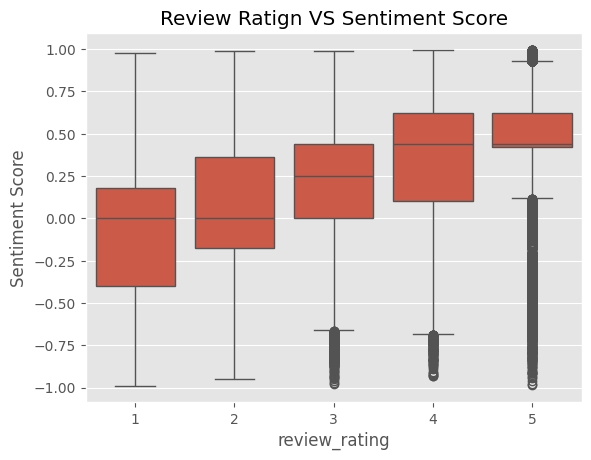

In [19]:
sns.boxplot(df,x='review_rating',y='Sentiment Score')
plt.title('Review Ratign VS Sentiment Score')
plt.show()

In [20]:
g=df.groupby(df['Review Date'].dt.to_period('M')).agg({'review_rating':'mean','Sentiment Score':'mean'})

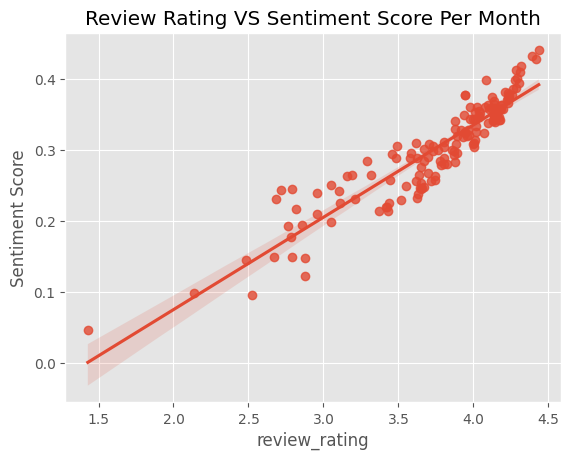

Correlation Coefficient:  0.9241477063673771


In [21]:
sns.regplot(g,x='review_rating',y='Sentiment Score')
plt.title('Review Rating VS Sentiment Score Per Month')
plt.show()

print('Correlation Coefficient: ',g['review_rating'].corr(g['Sentiment Score']))

#There is Strong Positive Correlation betwenn sentiment scores and rating given by user

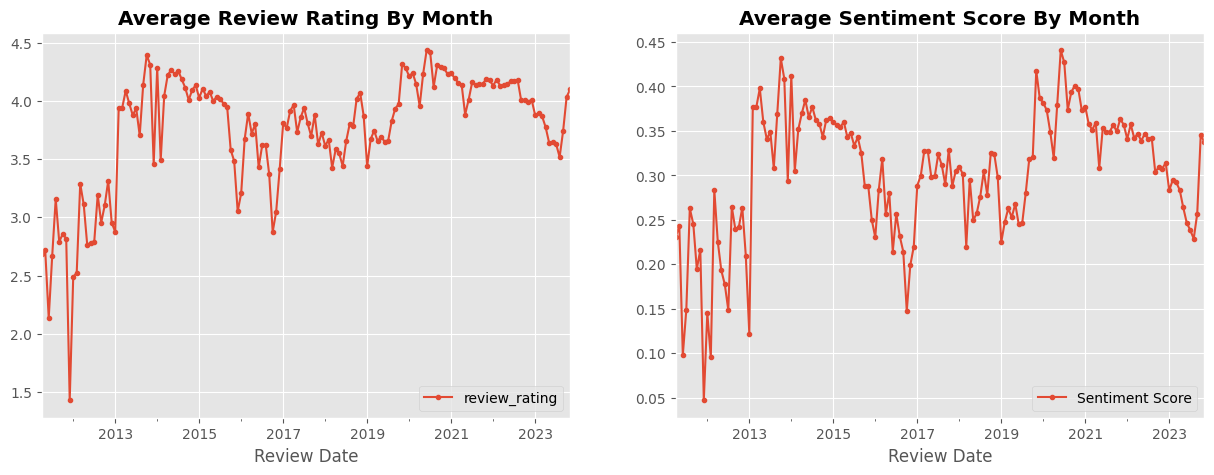

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

g.plot(ax=ax1,y='review_rating',marker='.')
ax1.set_title('Average Review Rating By Month',fontweight='bold')

g.plot(ax=ax2,y='Sentiment Score',marker='.')
ax2.set_title('Average Sentiment Score By Month',fontweight='bold')

plt.show()

# Both sets of data exhibit roughly similar pattern when plotted as line graph.

In [23]:
g=df.groupby(df['Author App Version']).agg({'review_rating':'mean','Sentiment Score':'mean'}).sort_index()#.sort_values('review_rating',ascending=False)

g.style.background_gradient(cmap='Reds')

,review_rating,Sentiment Score
Author App Version,,
1.0,3.811213,0.220879
1.1,2.514286,0.143452
2.0,2.866601,0.209662
2.2,1.752772,0.080497
2.3,2.795635,0.203460
2.4,3.021898,0.223448
2.5,3.597624,0.303966
3.0,4.111224,0.378939
3.1,3.801630,0.320967


In [24]:
g=df.groupby(df['Review Date'].dt.to_period('M'))['review_text'].count()

fig=px.line(g,x=[str(i) for i in g.index],y=g.values)
fig.update_traces(mode='lines+markers',marker_size=10,marker=dict(color=g.values,colorscale='plasma'))
fig.update_layout(height=600,template='plotly_dark')
fig.update_layout(hovermode='x unified')
fig.update_layout(title=dict(text='Popularity Of Linkedin App On Play Store',font_family='Arial Black'))
fig.update_xaxes(title_text='Month')
fig.update_yaxes(title_text='Number Of Reviews')
fig.update_xaxes(tickvals=[str(i) for i in g.index],tickfont_size=8,tickangle=45)
fig.show()